<a href="https://colab.research.google.com/github/hyunku/Brain-Machine_Interface_System/blob/main/5sec_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.4 MB/s 


In [2]:
##필요 모듈 import
import os
import sys
import pandas as pd
import numpy as np
from scipy import signal
import mne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from datetime import datetime
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math
from google.colab import drive
import joblib
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


In [3]:
# define parameters
n_channels = 6 
s_freq = 128  # in Hertz
ch_names = ['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']
ch_types = ['eeg'] * n_channels
all_ch_names = ch_names + ['Task','STM']
all_ch_types = ch_types + ['misc','misc']
p_detrend = 1 # 0: OFF, 1: On
p_normalization = 1 # 0: do not, 1: [0, 1] scaling, 2: standardization (x-mean)/var
p_n_filenames = 7
p_ica_flag = 1
p_ts_psd_flag = 0
l_freqs = 1
h_freqs = 60

# 연희 모델 검증

In [ ]:
eeg = pd.read_csv("/content/drive/Shareddrives/MindPong/code/rawdata/eeg+train/try_psd/preprocessed_16days_update.csv")
eeg = eeg.iloc[:,1:]
eeg

,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma,event
0,2022-07-15 03:53:43.005288,-8.012494e+09,-2.860742e+10,-2.479036e+10,-2.443542e+10,-2.544167e+10,-2.036193e+10,-8.045803e+09,-2.861909e+10,-2.477033e+10,...,-2.442412e+10,-2.541881e+10,-2.032130e+10,-8.067544e+09,-2.864487e+10,-2.476928e+10,-2.442586e+10,-2.542091e+10,-2.032434e+10,-1
1,2022-07-15 03:53:43.520364,-8.008656e+09,-2.861108e+10,-2.479984e+10,-2.444083e+10,-2.544892e+10,-2.037084e+10,-8.058765e+09,-2.863288e+10,-2.478047e+10,...,-2.442936e+10,-2.542329e+10,-2.032819e+10,-8.066993e+09,-2.864560e+10,-2.477257e+10,-2.442784e+10,-2.542202e+10,-2.032739e+10,-1
2,2022-07-15 03:53:44.026203,-8.009610e+09,-2.860686e+10,-2.479559e+10,-2.443557e+10,-2.544080e+10,-2.036521e+10,-8.060531e+09,-2.863573e+10,-2.477809e+10,...,-2.442847e+10,-2.542327e+10,-2.033231e+10,-8.064065e+09,-2.864343e+10,-2.477482e+10,-2.442771e+10,-2.542215e+10,-2.033030e+10,-1
3,2022-07-15 03:53:44.536857,-8.008431e+09,-2.861457e+10,-2.480828e+10,-2.444425e+10,-2.545120e+10,-2.037621e+10,-8.058579e+09,-2.863598e+10,-2.477270e+10,...,-2.442841e+10,-2.542247e+10,-2.033255e+10,-8.062589e+09,-2.864384e+10,-2.477969e+10,-2.442972e+10,-2.542368e+10,-2.033354e+10,-1
4,2022-07-15 03:53:45.046329,-8.006223e+09,-2.860545e+10,-2.480003e+10,-2.443500e+10,-2.543912e+10,-2.036774e+10,-8.056021e+09,-2.863867e+10,-2.476944e+10,...,-2.442860e+10,-2.542211e+10,-2.033425e+10,-8.058559e+09,-2.864100e+10,-2.478084e+10,-2.442910e+10,-2.542292e+10,-2.033568e+10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60610,2022-08-04 03:18:06.169118,3.863451e+09,1.539810e+09,-8.402576e+08,-1.877600e+09,-1.342357e+09,6.375323e+09,3.756707e+09,1.425880e+09,-9.817256e+08,...,-1.902052e+09,-1.361234e+09,6.343078e+09,3.825454e+09,1.501131e+09,-8.768235e+08,-1.899824e+09,-1.358551e+09,6.344399e+09,1
60611,2022-08-04 03:18:06.679120,3.869584e+09,1.545872e+09,-8.312726e+08,-1.873708e+09,-1.338893e+09,6.382324e+09,3.736095e+09,1.428414e+09,-9.846491e+08,...,-1.906994e+09,-1.362909e+09,6.344054e+09,3.819582e+09,1.499297e+09,-8.786797e+08,-1.909474e+09,-1.365035e+09,6.341866e+09,1
60612,2022-08-04 03:18:07.189115,3.872389e+09,1.554156e+09,-8.236501e+08,-1.876288e+09,-1.340820e+09,6.384023e+09,3.722586e+09,1.443878e+09,-9.694828e+08,...,-1.915326e+09,-1.365256e+09,6.341602e+09,3.814696e+09,1.501334e+09,-8.763989e+08,-1.917133e+09,-1.367623e+09,6.340695e+09,1
60613,2022-08-04 03:18:07.699118,3.878095e+09,1.559034e+09,-8.162485e+08,-1.874426e+09,-1.338939e+09,6.389834e+09,3.730039e+09,1.466621e+09,-9.370388e+08,...,-1.923066e+09,-1.368565e+09,6.342943e+09,3.814466e+09,1.505933e+09,-8.697809e+08,-1.920290e+09,-1.366005e+09,6.345358e+09,1


In [ ]:
# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.8) # train data : 80% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

In [ ]:
# QuadraticDiscriminantAnalysis (QDA)
cv=KFold(n_splits=10,random_state=123,shuffle=True)
model_qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
scores=cross_val_score(model_qda,X_train,y_train,cv=cv)
y_pred = model_qda.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)
cm_df.columns = ['pred_-1', 'pred_1']
cm_df.index = ['real_-1','real_1']
cm_df.T

,real_-1,real_1
pred_-1,370,392
pred_1,6377,4984


In [ ]:
TP = cm_df.T.iloc[0,0]
FP = cm_df.T.iloc[0,1]
FN = cm_df.T.iloc[1,0]
TN = cm_df.T.iloc[1,1]
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.44163985812092715

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.49      0.05      0.10      6747
           1       0.44      0.93      0.60      5376

    accuracy                           0.44     12123
   macro avg       0.46      0.49      0.35     12123
weighted avg       0.46      0.44      0.32     12123



In [ ]:
# check entropy
# 0 : low Impurity
# 1 : high Impurity

from math import log2
N=2 #state
p=accuracy #accuracy
entropy = log2(N) + p*log2(p) + (1-p)*log2((1-p)/(N-1))
entropy

0.009849804410189844

In [ ]:
# LinearRegression

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [ ]:
#y_pred Change to 1 and -1 compared to previous values
pred1=[]
if y_pred[0]>=0:
    pred1.append(1)
else:
    pred1.append(-1)
    
for i in range(len(y_pred)-1):
    if y_pred[i+1]-y_pred[i]>0.000:    ##
        pred1.insert(i+1, 1)
    else:
        pred1.insert(i+1,-1)
pred1=np.array(pred1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred1)
cm_df = pd.DataFrame(cm)
cm_df.columns = ['pred_-1', 'pred_1']
cm_df.index = ['real_-1','real_1']
cm_df.T

,real_-1,real_1
pred_-1,3366,2637
pred_1,3381,2739


In [ ]:
TP = cm_df.T.iloc[0,0]
FP = cm_df.T.iloc[0,1]
FN = cm_df.T.iloc[1,0]
TN = cm_df.T.iloc[1,1]
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.5035882207374413

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

          -1       0.56      0.50      0.53      6747
           1       0.45      0.51      0.48      5376

    accuracy                           0.50     12123
   macro avg       0.50      0.50      0.50     12123
weighted avg       0.51      0.50      0.51     12123



In [ ]:
# check entropy
# 0 : low Impurity
# 1 : high Impurity

from math import log2
N=2 #state
p=accuracy #accuracy
entropy = log2(N) + p*log2(p) + (1-p)*log2((1-p)/(N-1))
entropy

3.7150662774099175e-05

# 회영이 모델 검증

In [ ]:
eeg = pd.read_csv("/content/drive/MyDrive/MNE/make_pretrain/hoeyoung/eeg_2022-10-12_15-01-31.csv")
train = pd.read_csv("/content/drive/MyDrive/MNE/make_pretrain/hoeyoung/session_train_2022-10-12_15-01-38.csv")

In [ ]:
# use 6chan data
eeg = eeg.iloc[:,:62*6+1]
eeg.reset_index(drop=True, inplace=True)
eeg

,timestamp,ch0-time0,ch0-time1,ch0-time2,ch0-time3,ch0-time4,ch0-time5,ch0-time6,ch0-time7,ch0-time8,...,ch5-time52,ch5-time53,ch5-time54,ch5-time55,ch5-time56,ch5-time57,ch5-time58,ch5-time59,ch5-time60,ch5-time61
0,2022-10-12T15:01:32.905723,24019.855144,24017.910542,24018.581095,24016.368272,24008.813382,23991.267263,23989.836751,23976.738629,23981.208978,...,22807.496525,22808.994092,22808.725871,22781.099115,22747.951478,22765.609356,22771.085533,22780.227397,22753.159434,22757.629783
1,2022-10-12T15:01:33.414495,24024.839583,24025.018397,24045.157319,24027.812365,24036.350731,24021.375063,24036.462490,24026.873592,24035.121385,...,22899.853933,22889.080392,22897.931683,22893.528389,22867.063924,22873.277709,22865.834578,22854.815168,22831.323484,22841.448825
2,2022-10-12T15:01:33.919484,24072.582909,24075.913319,24074.751028,24085.278700,24052.175766,24033.333246,24012.993158,23993.614196,23995.067059,...,22769.006821,22767.442199,22741.313009,22742.967039,22723.252800,22726.560858,22720.861163,22731.969980,22737.446158,22744.419902
3,2022-10-12T15:01:34.431333,23906.844724,23913.662006,23910.957445,23926.178983,23923.250904,23930.023483,23924.614361,23926.000169,23929.621152,...,22762.725981,22762.748332,22739.413111,22737.848489,22743.749350,22745.716303,22770.035001,22749.583155,22760.311992,22785.792981
4,2022-10-12T15:01:34.943229,23774.522397,23810.285188,23827.048996,23819.784679,23816.588380,23813.123860,23827.116052,23814.688482,23819.359996,...,22913.667311,22905.888904,22907.498229,22903.586674,22923.747948,22896.635282,22896.434116,22883.961843,22867.801531,22866.885110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,2022-10-12T15:32:11.749296,15559.406943,15330.614487,15063.309975,14625.260487,14499.733090,14400.960732,14359.855874,14464.037354,14626.176909,...,12852.677745,12811.103500,12803.772128,12759.247453,12748.496264,12723.819938,12652.115542,12601.891172,12535.126511,12492.457031
3593,2022-10-12T15:32:12.261388,16278.797839,16252.936870,16164.334555,16142.586308,16073.720583,16091.199647,15986.749945,16056.062705,16021.819833,...,12772.144410,12846.128684,12887.188838,12953.595871,13009.072901,13164.171656,13255.456180,13387.890266,13490.574180,13632.843033
3594,2022-10-12T15:32:12.763349,17378.727183,17452.152664,17567.666479,17621.243611,17655.710000,17663.376649,17651.530224,17661.744971,17619.723692,...,10099.300456,10307.708121,10462.136324,10591.955256,10689.431213,10732.391266,10719.248440,10760.621519,10735.453455,10766.723545
3595,2022-10-12T15:32:13.278505,14597.924304,14634.379999,14620.566621,14656.061191,14625.372246,14640.459673,14609.524859,14649.623889,14643.655973,...,11892.737376,11917.972495,11913.479795,11947.253281,11931.562356,11934.646897,11957.691545,11978.970406,11992.850839,12031.564061


In [7]:
''' Function about extract filtered data from data measured by 0.5sec and extract bandpass data from data measuerd by 3sec'''

def filtering_bandpass_update(data):

##### make filtered data by 0.5sec

  info = mne.create_info(ch_names=ch_names, sfreq=s_freq, ch_types='eeg') # make info
  st_idx = 1
  time = 62
  ch_li = []  

  # gather and average from buffer
  for chan in range(n_channels):
    ch_li.append(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].sum(axis=1) / len(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].T)) # 1 ~ 62*1 + 1, 62*1 + 1 ~ 62*2 + 1

  ch_df = pd.DataFrame(ch_li).T
  t = pd.DataFrame(data.iloc[:,0])

  # dataframe -> mne rawarray
  raw = mne.io.RawArray(ch_df.T, info, verbose=False)    # make mne object

  # filtering (by Hertz)
  raw_filtered = raw.filter(l_freq=60,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 60

  # make column names
  ch_names_arr = np.char.array(['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']) # for 6 channel
  raw_filtered.columns = ch_names_arr

  # add time column
  df = pd.concat([t,raw_filtered], axis=1)
  origin_df = df.iloc[5:,:]
  origin_df.reset_index(drop=True, inplace=True)

  
##### make bandpass by 3sec

  # initialize info
  info = mne.create_info(ch_names=ch_names, sfreq=s_freq, ch_types='eeg') # make info
  st_idx = 1
  time = 62
  ch_li = []

  # gather and average from buffer
  for chan in range(n_channels):
    ch_li.append(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].sum(axis=1) / len(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].T)) # 1 ~ 62*1 + 1, 62*1 + 1 ~ 62*2 + 1

  ch_df = pd.DataFrame(ch_li).T

  # time rolling to gather 3sec data
  ch_df = ch_df.rolling(window=6).mean().iloc[5:,:]
  ch_df.reset_index(drop=True, inplace=True)

  # dataframe -> mne rawarray
  raw = mne.io.RawArray(ch_df.T, info, verbose=False)

  # get bandpass (by Hertz)
  delta_band = raw.filter(l_freq=4,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 4
  theta_band = raw.filter(l_freq=8,h_freq=4,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 4 ~ 8
  alpha_band = raw.filter(l_freq=12,h_freq=8,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 8 ~12
  beta_band = raw.filter(l_freq=30,h_freq=12,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 12 ~ 30
  gamma_band = raw.filter(l_freq=45,h_freq=30,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 30 ~ 45

  # make column names
  ch_names_arr = np.char.array(['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']) # for 6 channel
  band_labels_arr = np.char.array(["-Delta", "-Theta", "-Alpha", "-Beta", "-Gamma"])
  ch_band_labels = ch_names_arr[np.newaxis, :] + band_labels_arr[:, np.newaxis]
  new_cols = ch_band_labels.flatten()

  # gather each bandpass data
  banded = pd.concat([delta_band, theta_band, alpha_band, beta_band, gamma_band], axis=1)
  banded.columns = new_cols

###### gather 0.5sec origin data and 3sec bandpass data

  filtered = pd.concat([origin_df, banded], axis=1)

  return filtered

In [ ]:
eeg = filtering_bandpass_update(eeg)
# get ready to merge train data to eeg data

eeg['timestamp'] = pd.to_datetime(eeg['timestamp'])
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = train.rename(columns={' event(1:up':'event'})

eeg['event']=0

# deploy target data to eeg data by timestamp (merge train data and eeg data)

for i in range(0,len(train)-1):
  for t in range(0,len(eeg)):
    if train['timestamp'][i]< eeg['timestamp'][t] and (train['timestamp'][i+1]>eeg['timestamp'][t])==True:
       eeg.event[t]=train.event[i]

# drop the columns which doesn't have target data
eeg.drop(eeg.loc[eeg['event']==0].index, inplace=True)
eeg.reset_index(drop=True, inplace=True)

eeg

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 60.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma,event
0,2022-10-12 15:01:40.570337,2.407097e+10,1.196585e+10,-6.456269e+09,1.146589e+10,1.922022e+10,2.287504e+10,2.365455e+10,1.150059e+10,-6.895160e+09,...,1.126091e+10,1.899498e+10,2.271412e+10,2.387653e+10,1.169975e+10,-6.690423e+09,1.126395e+10,1.899715e+10,2.271512e+10,1
1,2022-10-12 15:01:41.082834,2.376785e+10,1.164963e+10,-6.780028e+09,1.113463e+10,1.892102e+10,2.253927e+10,2.385025e+10,1.171038e+10,-6.689645e+09,...,1.128812e+10,1.903830e+10,2.274201e+10,2.393434e+10,1.175964e+10,-6.645006e+09,1.131139e+10,1.906370e+10,2.277207e+10,1
2,2022-10-12 15:01:41.593430,2.404788e+10,1.194815e+10,-6.504294e+09,1.143065e+10,1.921566e+10,2.284751e+10,2.398355e+10,1.184580e+10,-6.569905e+09,...,1.122865e+10,1.899521e+10,2.268577e+10,2.385544e+10,1.168344e+10,-6.738540e+09,1.122539e+10,1.899157e+10,2.268240e+10,1
3,2022-10-12 15:01:42.106199,2.377660e+10,1.166322e+10,-6.795110e+09,1.113127e+10,1.894668e+10,2.254661e+10,2.426501e+10,1.209738e+10,-6.336759e+09,...,1.134736e+10,1.912917e+10,2.281991e+10,2.395976e+10,1.179188e+10,-6.644476e+09,1.132441e+10,1.910404e+10,2.278981e+10,1
4,2022-10-12 15:01:42.616824,2.401903e+10,1.192432e+10,-6.558186e+09,1.138923e+10,1.920513e+10,2.281371e+10,2.419387e+10,1.199761e+10,-6.454345e+09,...,1.121218e+10,1.900991e+10,2.267577e+10,2.386627e+10,1.169803e+10,-6.758340e+09,1.121746e+10,1.901689e+10,2.268380e+10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,2022-10-12 15:31:56.881593,1.579293e+10,4.793669e+09,-1.156114e+10,1.216459e+09,1.328311e+10,1.216591e+10,1.577119e+10,4.802908e+09,-1.151692e+10,...,1.219281e+09,1.330729e+10,1.216126e+10,1.578145e+10,4.778672e+09,-1.154599e+10,1.216164e+09,1.330325e+10,1.215810e+10,1
3549,2022-10-12 15:31:57.394766,1.576188e+10,4.768698e+09,-1.157923e+10,1.192265e+09,1.326878e+10,1.216280e+10,1.575405e+10,4.784122e+09,-1.153386e+10,...,1.202601e+09,1.329518e+10,1.213987e+10,1.576744e+10,4.769519e+09,-1.155280e+10,1.207292e+09,1.329910e+10,1.214276e+10,1
3550,2022-10-12 15:31:57.908876,1.578275e+10,4.782908e+09,-1.157089e+10,1.206342e+09,1.327372e+10,1.214003e+10,1.574591e+10,4.776866e+09,-1.153875e+10,...,1.194583e+09,1.328743e+10,1.212447e+10,1.575715e+10,4.757311e+09,-1.156392e+10,1.196348e+09,1.329048e+10,1.212691e+10,1
3551,2022-10-12 15:31:58.425273,1.574567e+10,4.752072e+09,-1.159460e+10,1.176692e+09,1.325510e+10,1.212740e+10,1.573799e+10,4.775443e+09,-1.153584e+10,...,1.195293e+09,1.329251e+10,1.212249e+10,1.574502e+10,4.749621e+09,-1.156887e+10,1.189715e+09,1.328730e+10,1.211861e+10,1


In [ ]:
# data split to X / Y (input / target)
eeg = eeg.copy()
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
# train_length = math.ceil(len(eeg) * 0.9) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg
y_train= train_event

In [ ]:
# LinearRegression

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_train)

In [ ]:
len(y_pred)

3553

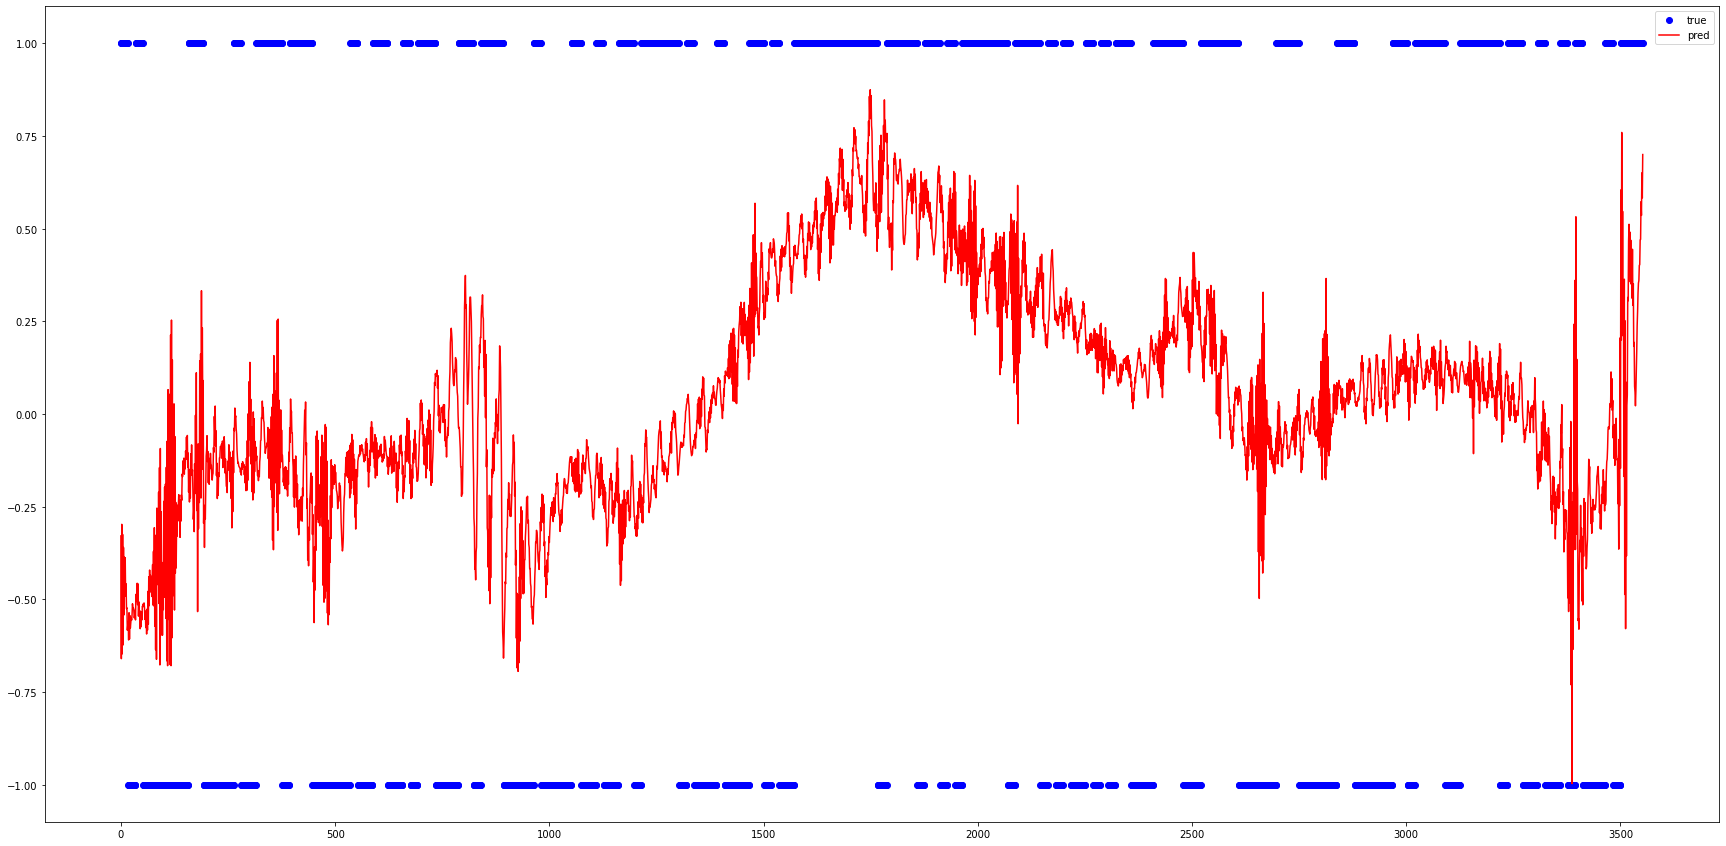

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(y_train, 'bo', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

In [ ]:
result_df = pd.DataFrame({'timestamp':eeg['timestamp'],
                          'real':eeg['event'],
                          'pred':y_pred})
result_df = result_df.iloc[1:-2] # 초당 1개 찍힌 데이터 제거(첫번째), 10개 단위(5초) 맞춰주기
result_df.reset_index(drop=True, inplace=True)
result_df

,timestamp,real,pred
0,2022-10-12 15:01:41.082834,1,-0.659883
1,2022-10-12 15:01:41.593430,1,-0.297346
2,2022-10-12 15:01:42.106199,1,-0.647107
3,2022-10-12 15:01:42.616824,1,-0.324599
4,2022-10-12 15:01:43.129807,1,-0.622976
...,...,...,...
3545,2022-10-12 15:31:55.856701,1,0.470153
3546,2022-10-12 15:31:56.369662,1,0.471389
3547,2022-10-12 15:31:56.881593,1,0.572906
3548,2022-10-12 15:31:57.394766,1,0.536139


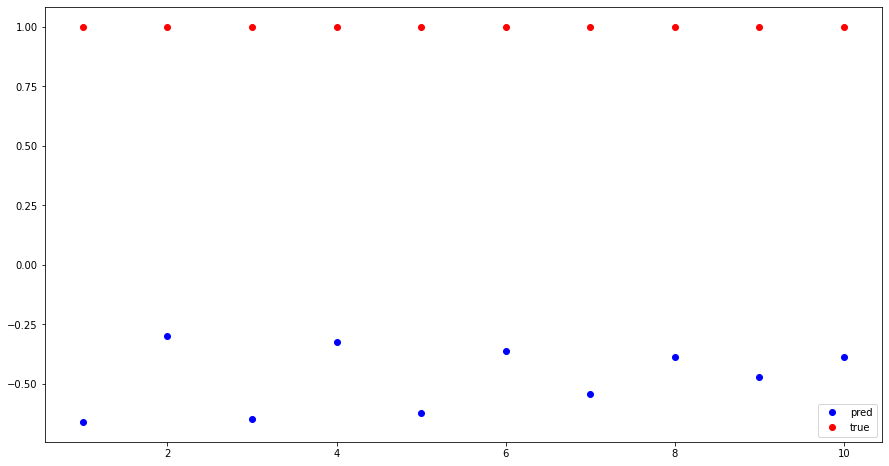

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(result_df['pred'].iloc[:10], 'bo', label='pred')
plt.plot(result_df['real'].iloc[:10], 'ro', label='true')
plt.legend()

In [ ]:
# 1. 5초동안의 amplitude 비교
amplitude_target = []
for i in range(0,len(result_df),10):
  if result_df['pred'][i] > result_df['pred'][i+9]:
    amplitude_target.append(-1)
  else:
    amplitude_target.append(1)

len(amplitude_target)

355

In [ ]:
# 2. 5초동안 낙폭 count 비교
count_target = []
count_target_imsi = []
for i in range(0,len(result_df),10):
  count_target_imsi.clear()
  for j in range(i,i+9):
    if result_df['pred'][j] < result_df['pred'][j+1]:
      count_target_imsi.append(1)
    else:
      count_target_imsi.append(-1)
  up_sig_5sec = count_target_imsi.count(1)
  down_sig_5sec = count_target_imsi.count(-1)
  if up_sig_5sec > down_sig_5sec:
    count_target.append(1)
  else:
    count_target.append(-1)
      
len(count_target)

355

In [ ]:
# 원래 target값도 5초에 맞게 변환 -> count기준
target_5sec = []
sig_li = []
for i in range(0,len(result_df),10):
  sig_li.clear()
  for j in range(i,i+9):
    sig_li.append(result_df['real'][j])
  up_sig_5 = sig_li.count(1)
  down_sig_5 = sig_li.count(-1)
  if up_sig_5 > down_sig_5:
    target_5sec.append(1)
  else:
    target_5sec.append(-1)

len(target_5sec)

355

In [ ]:
pred_df = pd.DataFrame({'real':target_5sec,
                  'cnt_pred':count_target,
                  'amplitude_pred':amplitude_target})
pred_df

,real,cnt_pred,amplitude_pred
0,1,1,1
1,1,1,-1
2,-1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
350,1,-1,-1
351,1,1,1
352,1,1,-1
353,1,1,1


증감 횟수에 따른 검증

In [ ]:
# validate with using updown signal count prediction
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['real'], pred_df['cnt_pred'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['pred_-1', 'pred_1']
cm_df.index = ['real_-1','real_1']
cm_df.T

,real_-1,real_1
pred_-1,74,96
pred_1,94,91


In [ ]:
TP = cm_df.T.iloc[0,0]
FP = cm_df.T.iloc[0,1]
FN = cm_df.T.iloc[1,0]
TN = cm_df.T.iloc[1,1]
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.4647887323943662

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_df['real'], pred_df['cnt_pred']))

              precision    recall  f1-score   support

          -1       0.44      0.44      0.44       168
           1       0.49      0.49      0.49       187

    accuracy                           0.46       355
   macro avg       0.46      0.46      0.46       355
weighted avg       0.47      0.46      0.46       355



In [ ]:
# check entropy
# 0 : low Impurity
# 1 : high Impurity

from math import log2
N=2 #state
p=accuracy #accuracy
entropy = log2(N) + p*log2(p) + (1-p)*log2((1-p)/(N-1))
entropy

0.003580365702151922

진폭에 따른 검증

In [ ]:
# validate with using updown signal amplitude prediction
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['real'], pred_df['amplitude_pred'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['pred_-1', 'pred_1']
cm_df.index = ['real_-1','real_1']
cm_df.T

,real_-1,real_1
pred_-1,78,94
pred_1,90,93


In [ ]:
TP = cm_df.T.iloc[0,0]
FP = cm_df.T.iloc[0,1]
FN = cm_df.T.iloc[1,0]
TN = cm_df.T.iloc[1,1]
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.48169014084507045

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_df['real'], pred_df['amplitude_pred']))

              precision    recall  f1-score   support

          -1       0.45      0.46      0.46       168
           1       0.51      0.50      0.50       187

    accuracy                           0.48       355
   macro avg       0.48      0.48      0.48       355
weighted avg       0.48      0.48      0.48       355



In [ ]:
# check entropy
# 0 : low Impurity
# 1 : high Impurity

from math import log2
N=2 #state
p=accuracy #accuracy
entropy = log2(N) + p*log2(p) + (1-p)*log2((1-p)/(N-1))
entropy

0.0009675460586004436

# 현구 모델 검증

In [4]:
eeg = pd.read_csv("/content/drive/MyDrive/MNE/make_pretrain/hyunku/eeg_2022-10-27_16-22-41.csv")
train = pd.read_csv("/content/drive/MyDrive/MNE/make_pretrain/hyunku/session_train_2022-10-27_16-22-49.csv")

In [5]:
# use 6chan data
eeg = eeg.iloc[:,:62*6+1]
eeg

,timestamp,ch0-time0,ch0-time1,ch0-time2,ch0-time3,ch0-time4,ch0-time5,ch0-time6,ch0-time7,ch0-time8,...,ch5-time52,ch5-time53,ch5-time54,ch5-time55,ch5-time56,ch5-time57,ch5-time58,ch5-time59,ch5-time60,ch5-time61
0,2022-10-27T16:22:42.291283,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,...,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352
1,2022-10-27T16:22:42.799339,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,...,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352
2,2022-10-27T16:22:43.304338,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,...,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352
3,2022-10-27T16:22:43.816351,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,...,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352
4,2022-10-27T16:22:44.324351,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,...,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2022-10-27T16:56:16.095507,31.270090,-9947.621518,952.676052,-10252.141685,1392.044293,-10309.228040,1248.143762,-10120.959296,549.785858,...,3259.487839,-7820.160129,3092.006217,-7516.198756,2586.633275,-6874.100193,1737.691669,-5894.289123,586.085091,-4614.070608
3948,2022-10-27T16:56:16.605377,-2133.161084,-7878.520534,-3761.262150,-6607.332123,-5375.281617,-5122.617498,-6831.117789,-3507.189871,-8055.702812,...,-2296.351170,-1556.620187,-3780.886982,-87.976466,-5141.683536,1200.691009,-6272.145363,2215.974297,-7106.446577,2888.672398
3949,2022-10-27T16:56:17.114698,-9703.451062,644.870179,-10119.439378,1285.337065,-10274.918112,1380.443738,-10190.182649,898.383665,-9860.784991,...,-7848.457438,3189.325713,-7683.300398,2819.069066,-7172.719499,2109.647049,-6329.388181,1071.721443,-5162.649472,-217.974212
3950,2022-10-27T16:56:17.624766,-8312.032618,-3096.923601,-7140.309470,-4734.099476,-5733.177749,-6274.224076,-4153.490562,-7592.418205,-2528.071705,...,-2118.699505,-3258.772583,-610.582603,-4683.629237,759.020538,-5908.951868,1883.000360,-6851.524931,2684.690378,-7498.987913


In [8]:
eeg = filtering_bandpass_update(eeg)
eeg['timestamp'] = pd.to_datetime(eeg['timestamp'])
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = train.rename(columns={' event(1:up':'event'})

eeg['event']=0

for i in range(0,len(train)-1):
  for t in range(0,len(eeg)):
    if train['timestamp'][i]< eeg['timestamp'][t] and (train['timestamp'][i+1]>eeg['timestamp'][t])==True:
       eeg.event[t]=train.event[i]

# drop the columns which doesn't have target data
eeg.drop(eeg.loc[eeg['event']==0].index, inplace=True)
eeg.reset_index(drop=True, inplace=True)
eeg

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 60.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma,event
0,2022-10-27 16:22:51.975656,-1.875003e+11,-1.875003e+11,-1.875003e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.874988e+11,-1.874988e+11,-1.874988e+11,...,-1.874990e+11,-1.874989e+11,-1.874990e+11,-1.874988e+11,-1.874988e+11,-1.874988e+11,-1.874990e+11,-1.874989e+11,-1.874990e+11,-1
1,2022-10-27 16:22:52.485638,-1.875003e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.874988e+11,-1.874989e+11,-1.874989e+11,...,-1.874990e+11,-1.874989e+11,-1.874991e+11,-1.874988e+11,-1.874989e+11,-1.874989e+11,-1.874990e+11,-1.874989e+11,-1.874991e+11,-1
2,2022-10-27 16:22:52.995638,-1.875003e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.874988e+11,-1.874989e+11,-1.874989e+11,...,-1.874990e+11,-1.874990e+11,-1.874991e+11,-1.874988e+11,-1.874989e+11,-1.874989e+11,-1.874990e+11,-1.874990e+11,-1.874991e+11,-1
3,2022-10-27 16:22:53.506200,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.874989e+11,-1.874989e+11,-1.874989e+11,...,-1.874991e+11,-1.874990e+11,-1.874992e+11,-1.874989e+11,-1.874989e+11,-1.874989e+11,-1.874991e+11,-1.874990e+11,-1.874992e+11,-1
4,2022-10-27 16:22:54.016199,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.875004e+11,-1.874989e+11,-1.874990e+11,-1.874990e+11,...,-1.874991e+11,-1.874991e+11,-1.874992e+11,-1.874989e+11,-1.874990e+11,-1.874990e+11,-1.874991e+11,-1.874991e+11,-1.874992e+11,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,2022-10-27 16:56:04.360027,-5.029730e+09,-4.997997e+09,-3.046545e+09,-2.601168e+09,-2.765888e+09,-2.333513e+09,-5.087250e+09,-5.056190e+09,-3.149099e+09,...,-2.652870e+09,-2.819963e+09,-2.383194e+09,-5.032089e+09,-5.005531e+09,-3.057575e+09,-2.608938e+09,-2.774727e+09,-2.339856e+09,1
3906,2022-10-27 16:56:04.870234,-5.073556e+09,-5.038423e+09,-3.108183e+09,-2.657808e+09,-2.826791e+09,-2.388077e+09,-5.096367e+09,-5.067090e+09,-3.195706e+09,...,-2.528478e+09,-2.694047e+09,-2.261680e+09,-5.008629e+09,-4.978493e+09,-3.003259e+09,-2.552425e+09,-2.719333e+09,-2.284521e+09,1
3907,2022-10-27 16:56:05.380834,-5.028395e+09,-4.992737e+09,-3.049773e+09,-2.604447e+09,-2.770894e+09,-2.339205e+09,-5.015905e+09,-4.990551e+09,-3.169476e+09,...,-2.498270e+09,-2.663265e+09,-2.234165e+09,-4.981392e+09,-4.950012e+09,-2.978091e+09,-2.531555e+09,-2.697523e+09,-2.266827e+09,1
3908,2022-10-27 16:56:05.890825,-5.064064e+09,-5.025939e+09,-3.088023e+09,-2.638218e+09,-2.808042e+09,-2.372060e+09,-5.018222e+09,-4.990918e+09,-3.163995e+09,...,-2.536154e+09,-2.703775e+09,-2.272053e+09,-4.955631e+09,-4.921875e+09,-2.954771e+09,-2.507535e+09,-2.674496e+09,-2.243845e+09,1


In [9]:
# data split to X / Y (input / target)
eeg = eeg.copy()
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
# train_length = math.ceil(len(eeg) * 0.9) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg
y_train= train_event

In [10]:
# LinearRegression

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_train)

In [13]:
result_df = pd.DataFrame({'timestamp':eeg['timestamp'],
                          'real':eeg['event'],
                          'pred':y_pred})
result_df

,timestamp,real,pred
0,2022-10-27 16:22:51.975656,-1,0.258924
1,2022-10-27 16:22:52.485638,-1,0.258925
2,2022-10-27 16:22:52.995638,-1,0.258926
3,2022-10-27 16:22:53.506200,-1,0.258926
4,2022-10-27 16:22:54.016199,-1,0.258926
...,...,...,...
3905,2022-10-27 16:56:04.360027,1,0.036266
3906,2022-10-27 16:56:04.870234,1,0.058181
3907,2022-10-27 16:56:05.380834,1,0.045261
3908,2022-10-27 16:56:05.890825,1,0.071656


In [14]:
# 1. 5초동안의 amplitude 비교
amplitude_target = []
for i in range(0,len(result_df),10):
  if result_df['pred'][i] > result_df['pred'][i+9]:
    amplitude_target.append(-1)
  else:
    amplitude_target.append(1)

len(amplitude_target)

391

In [15]:
# 2. 5초동안 낙폭 count 비교
count_target = []
count_target_imsi = []
for i in range(0,len(result_df),10):
  count_target_imsi.clear()
  for j in range(i,i+9):
    if result_df['pred'][j] < result_df['pred'][j+1]:
      count_target_imsi.append(1)
    else:
      count_target_imsi.append(-1)
  up_sig_5sec = count_target_imsi.count(1)
  down_sig_5sec = count_target_imsi.count(-1)
  if up_sig_5sec > down_sig_5sec:
    count_target.append(1)
  else:
    count_target.append(-1)
      
len(count_target)

391

In [16]:
# 원래 target값도 5초에 맞게 변환 -> count기준
target_5sec = []
sig_li = []
for i in range(0,len(result_df),10):
  sig_li.clear()
  for j in range(i,i+9):
    sig_li.append(result_df['real'][j])
  up_sig_5 = sig_li.count(1)
  down_sig_5 = sig_li.count(-1)
  if up_sig_5 > down_sig_5:
    target_5sec.append(1)
  else:
    target_5sec.append(-1)

len(target_5sec)

391

In [17]:
pred_df = pd.DataFrame({'real':target_5sec,
                  'cnt_pred':count_target,
                  'amplitude_pred':amplitude_target})
pred_df

,real,cnt_pred,amplitude_pred
0,-1,-1,-1
1,-1,-1,-1
2,1,-1,-1
3,1,-1,-1
4,-1,-1,-1
...,...,...,...
386,-1,1,1
387,-1,1,-1
388,1,-1,-1
389,1,-1,-1


증감 횟수에 따른 검증

In [18]:
# validate with using updown signal count prediction
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['real'], pred_df['cnt_pred'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['pred_-1', 'pred_1']
cm_df.index = ['real_-1','real_1']
cm_df.T

,real_-1,real_1
pred_-1,104,101
pred_1,92,94


In [19]:
TP = cm_df.T.iloc[0,0]
FP = cm_df.T.iloc[0,1]
FN = cm_df.T.iloc[1,0]
TN = cm_df.T.iloc[1,1]
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.5063938618925832

In [21]:
from sklearn.metrics import classification_report
print(classification_report(pred_df['real'], pred_df['cnt_pred']))

              precision    recall  f1-score   support

          -1       0.51      0.53      0.52       196
           1       0.51      0.48      0.49       195

    accuracy                           0.51       391
   macro avg       0.51      0.51      0.51       391
weighted avg       0.51      0.51      0.51       391



In [22]:
# check entropy
# 0 : low Impurity
# 1 : high Impurity

from math import log2
N=2 #state
p=accuracy
entropy = log2(N) + p*log2(p) + (1-p)*log2((1-p)/(N-1))
entropy

0.0001179622028836258

진폭에 따른 검증

In [23]:
# validate with using updown signal count prediction
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['real'], pred_df['amplitude_pred'])
cm_df = pd.DataFrame(cm)
cm_df.columns = ['pred_-1', 'pred_1']
cm_df.index = ['real_-1','real_1']
cm_df.T

,real_-1,real_1
pred_-1,103,99
pred_1,93,96


In [24]:
TP = cm_df.T.iloc[0,0]
FP = cm_df.T.iloc[0,1]
FN = cm_df.T.iloc[1,0]
TN = cm_df.T.iloc[1,1]
accuracy = (TP + TN) / (TP + FP + FN + TN)
accuracy

0.5089514066496164

In [25]:
from sklearn.metrics import classification_report
print(classification_report(pred_df['real'], pred_df['amplitude_pred']))

              precision    recall  f1-score   support

          -1       0.51      0.53      0.52       196
           1       0.51      0.49      0.50       195

    accuracy                           0.51       391
   macro avg       0.51      0.51      0.51       391
weighted avg       0.51      0.51      0.51       391



In [26]:
# check entropy
# 0 : low Impurity
# 1 : high Impurity

from math import log2
N=2 #state
p=accuracy
entropy = log2(N) + p*log2(p) + (1-p)*log2((1-p)/(N-1))
entropy

0.0002312119679626079